In [10]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
from shapely import geometry


In [ ]:

n = 8
pattern = (0.5, 1)
slab = ((0, 0), (0, 2), (2, 2), (2, 0))

options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
dimensions = 3  # x,y,phi

min_bound = np.array([0, 0, 0])
max_bound = np.array([2, 2, 2 * np.pi])
bounds = list(zip(min_bound, max_bound))



In [12]:

def s_intersection(a, b):
    poly1 = geometry.Polygon(a)
    poly2 = geometry.Polygon(b)
    intersection = poly1.intersection(poly2)
    return intersection.area


def real_cords(x):
    p = x[:2]
    phi = x[2]
    return geometry.Polygon([
        [p[0], p[1]],
        [p[0] + pattern[0] * np.cos(phi), p[1] + pattern[0] * np.sin(phi)],
        [p[0] + pattern[0] * np.cos(phi) - pattern[1] * np.sin(phi),
         p[1] + pattern[0] * np.sin(phi) + pattern[1] * np.cos(phi)],
        [p[0] - pattern[1] * np.sin(phi), p[1] + pattern[1] * np.cos(phi)]
    ])


def real_real_cords(x):
    p = x[:2]
    phi = x[2]
    return [
        [p[0], p[1]],
        [p[0] + pattern[0] * np.cos(phi), p[1] + pattern[0] * np.sin(phi)],
        [p[0] + pattern[0] * np.cos(phi) - pattern[1] * np.sin(phi),
         p[1] + pattern[0] * np.sin(phi) + pattern[1] * np.cos(phi)],
        [p[0] - pattern[1] * np.sin(phi), p[1] + pattern[1] * np.cos(phi)]
    ]


def func(all_pattern2):
    s = 0
    # Суммируем площади пересечений между фигурами
    for i in range(len(all_pattern2)):
        for j in range(i + 1, len(all_pattern2)):
            s += s_intersection(real_cords(all_pattern2[i]), real_cords(all_pattern2[j]))
    # Пени за выход за пределы slab
    for i in all_pattern2:
        s += real_cords(i).area - s_intersection(geometry.Polygon(slab), real_cords(i))
    return s

n==0

False

In [13]:
n==0
class Particle:
    def __init__(self, bounds, func, all_pattern2, index):
        self.func = func
        self.all_pattern2 = all_pattern2  # общий массив фигур
        self.index = index                # индекс фигуры, за которую отвечает частица
        self.bounds = bounds

        self.position = np.array([np.random.uniform(low, high) for low, high in bounds])
        self.velocity = np.zeros_like(self.position)
        self.best_position = self.position.copy()
        self.best_score = float('inf')

    def evaluate(self):
        # Обновляем позицию своей фигуры в полном массиве фигур
        self.all_pattern2[self.index] = self.position
        score = self.func(self.all_pattern2)
        if score < self.best_score:
            self.best_score = score
            self.best_position = self.position.copy()

    def update_velocity(self, global_best_position, w=0.7, c1=1.4, c2=1.4):
        r1, r2 = np.random.rand(2)
        cognitive = c1 * r1 * (self.best_position - self.position)
        social = c2 * r2 * (global_best_position - self.position)
        self.velocity = w * self.velocity + cognitive + social

    def update_position(self):
        self.position += self.velocity
        for i in range(len(self.bounds)):
            low, high = self.bounds[i]
            self.position[i] = np.clip(self.position[i], low, high)


class PSO:
    def __init__(self, func, bounds, n_particles_per_fig=30, max_iter=100, n_figures = 3):
        self.func = func
        self.bounds = bounds
        self.n_particles_per_fig = n_particles_per_fig
        self.max_iter = max_iter
        self.n_figures = n_figures

        # Инициализируем массив позиций фигур (n_figures, 3)
        self.all_pattern2 = np.array([np.array([np.random.uniform(low, high) for low, high in bounds]) for _ in range(n_figures)])

        # Частицы: для каждой фигуры создаем n_particles_per_fig частиц
        self.particles = []
        for fig_idx in range(n_figures):
            for _ in range(n_particles_per_fig):
                p = Particle(bounds, func, self.all_pattern2, fig_idx)
                self.particles.append(p)

        # Глобальные лучшие позиции для каждой фигуры (инициализируем None)
        self.global_best_positions = np.copy(self.all_pattern2)
        self.global_best_scores = np.full(n_figures, float('inf'))

    def optimize(self):
        for iteration in tqdm(range(self.max_iter), desc="Оптимизация PSO"):
            for fig_idx in range(self.n_figures):
                # Частицы, относящиеся к этой фигуре
                fig_particles = [p for p in self.particles if p.index == fig_idx]
                # Обновляем частицы этой фигуры
                for particle in fig_particles:
                    particle.update_velocity(self.global_best_positions[fig_idx])
                    particle.update_position()
                    particle.evaluate()

                # Обновляем глобальный лучший результат для фигуры
                for particle in fig_particles:
                    if particle.best_score < self.global_best_scores[fig_idx]:
                        self.global_best_scores[fig_idx] = particle.best_score
                        self.global_best_positions[fig_idx] = particle.best_position.copy()

                # Обновляем общие позиции фигур в массиве
                self.all_pattern2[fig_idx] = self.global_best_positions[fig_idx]

        # Возвращаем оптимальные позиции всех фигур и суммарное значение функции
        total_best_score = np.sum(self.global_best_scores)
        return self.all_pattern2, total_best_score



Оптимизация PSO: 100%|██████████| 200/200 [02:14<00:00,  1.49it/s]

Оптимальные позиции: 
[[1.5        1.51199003 3.14159265]
 [2.         1.         3.14159265]
 [1.         2.         3.14159265]
 [1.         0.5        1.57079633]
 [0.4997385  0.5        4.71238898]
 [1.5        1.         0.        ]
 [0.5        2.         3.14159265]]
Значение функции качества: 2.5057330570017316e-10


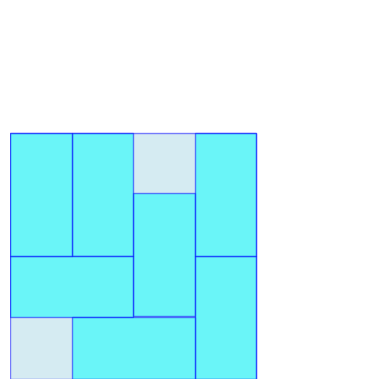

In [14]:

# Инициализация PSO
pso = PSO(func, bounds, n_particles_per_fig=20, max_iter=200, n_figures=n)
best_positions, best_score = pso.optimize()

print(f"Оптимальные позиции: \n{best_positions}")
print(f"Значение функции качества: {best_score}")

# Визуализация
fig, ax = plt.subplots()

polygon = patches.Polygon(slab, closed=True, fill=True, edgecolor='blue', facecolor='lightblue', alpha=0.5)
ax.add_patch(polygon)

for pos in best_positions:
    rect = patches.Polygon(real_real_cords(pos), closed=True, fill=True, edgecolor='blue', facecolor='cyan', alpha=0.5)
    ax.add_patch(rect)


ax.set_xlim(0, 3)
ax.set_ylim(0, 3)
ax.set_aspect('equal')
ax.grid(True)
ax.set_axis_off()

plt.show()
